# 3. Model tests
## 3.08 Model evaluation

# Verification and Hyperparameters

## 1. Metrics
#### Bias
description

$$
Bias = \sum_{n=1}^N   | \hat{y}_n - y_n |
$$

#### RMSE
description
$$
RMSE =\sqrt{ \sum_{n=1}^N  (\hat{y}_n - y_n)^2 }
$$

#### Nash-Sutcliffe-Efficiency

The classical version after Nash and Sutcliffe (1970) compares the squared error of the discharge forecast ($\hat{y}$) with the squared error of forecasting the mean discharge ($\overline{y}$). It is framed as skill-score, where larger values are better. In its formula, we need to sum over all $N$ forecasts:

$$
NSE = 1- \sum_{n=1}^N  \frac{(\hat{y}_n - y_n)^2}{( \overline{y} - y_n)^2} 
$$



Equivalently, the NSE can be seen as error reduction with respect to the reference forecast divided by the error of the reference forecast:

$$
NSE = \frac{\epsilon^2_{ref} - \epsilon^2}{\epsilon^2_{ref}}
$$
Thus, the idea of the NSE is that valuable predictions exhibit values $>0$ and reaches at most one.


#### Alternative Nash-Sutcliffe-Efficiency (for predicting differences)
When we start our prediction at time $t$, we can use the current discharge to predict tomorrow's discharge. This means that we are essentially predicting just differences in discharge.

Now that we use the discharge information at forecast init time (=analysis time), we observe another issue to preserve the idea of the NSE score.

Think of a model that is constantly predicting just the initial discharge value. Such a model can be close to the truth without adding predictive value. In the classical NSE however, such a model would have a high NSE, since the deviations from the truth are small.

Thus, to keep the interpretation of the NSE (comparing to the easiest forecast), we divide by the variance of the error of a persistence forecast ( $ \overline{y} \leftarrow $persistence). This formulation yields a NSE* of 0 when the forecast is just predicting the initial discharge value. The best achievable value is still 1.

$$
NSE^* = 1- \sum_{n=1}^N  \frac{(\hat{y}_n - y_n)^2}{(y_n - y_{persistence})^2} 
$$


## 2. Model evaluation

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import xarray as xr

import sys
sys.path.append('../../')
from python.aux.plot import plot_recurrent
from python.aux.utils import xr_to_datetime
from python.aux.utils_floodmodel import add_valid_time
from python.aux.verification import verify, ME, RMSE, RMSE_persistence, NSE, NSE_diff

In [2]:
def multif_metrics(pred, obs, method='total', name=None):
    """Calculates RMSE and NSE metrics for xr.DataArray in the multiforecast
    shape as defined in the previous notebooks.

    Parameters
    ----------
        pred   : xr.DataArray
        obs    : xr.DataArray
        method : str
    """
    if method == 'total':
        y_o = obs.loc[{'time': pred.time.values.ravel()}].values
        y_m = pred.values.ravel()
        rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
        nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))
        metr = xr.DataArray(data=np.array([rmse, nse]),
                            dims=['metric'],
                            coords=[['rmse', 'nse']],
                            name='total_metrics')

    elif method == 'per_day':
        forecast_range = pred.forecast_day
        fd_list = []
        for fd in forecast_range:
            pred_day = pred.sel(forecast_day=fd)
            y_o = obs.loc[{'time': pred_day.time.values.ravel()}].values
            y_m = pred_day.values.ravel()
            rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
            nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))
            fd_list.append([rmse, nse])
        metr = xr.DataArray(data=np.array(fd_list),
                            dims=['forecast_day', 'metric'],
                            coords=[range(np.array(fd_list).shape[0]), ['rmse', 'nse']],
                            name='per_day_metrics')
    if name:
        metr.name = f"{name}-{metr.name}"
    return metr

### 2.1 Comparing the models in the test period

#### Load the "truth" (reanalysis) at the test gridpoint and the model forecasts

In [3]:
truth_test = xr.open_dataset('../../data/glofas_reanalysis_test_period.nc')['dis']
fc_lr_test = xr.open_dataset('../../data/models/LinearRegression/linear_regression_result_test_period.nc')['prediction']
fc_svr_test = xr.open_dataset('../../data/models/SVR/support_vector_regression_result_test_period.nc')['prediction']
fc_gb_test = xr.open_dataset('../../data/models/GradientBoost/gradient_boost_result_test_period.nc')['prediction']
# tdnn: fc_tdnn_test = xr.open_dataset('../../data/models/-----.nc')['prediction']
# cnn: fc_cnn_test = xr.open_dataset('../../data/models/-----.nc')['prediction']

Before evaluation, we can quickly construct a persistence forecast in the same shape using on of the above xr.DataArray and the "truth" reanalysis data.

In [71]:
# initial state used for persistence
truth_init = truth_test.values.reshape(fc_lr_test.shape)[:,0]
# repeat the initial state for the whole forecast period i.e. persistence forecast
persistence_data = np.tile(truth_init, (15, 1)).transpose()
# easy way to get the same shape, dims, coords etc
persistence_test = fc_lr_test.copy()
persistence_test.values = persistence_data

In [74]:
lr_test = multif_metrics(fc_lr_test, truth_test, method='per_day', name='LinReg')
svr_test = multif_metrics(fc_svr_test, truth_test, method='per_day', name='SVR')
gb_test = multif_metrics(fc_gb_test, truth_test, method='per_day', name='GradBoost')
#tdnn_test = multif_metrics(fc_tdnn_test, truth_test, method='per_day', name='Time-delay neural net')
per_test = multif_metrics(persistence_test, truth_test, method='per_day', name='Persistence')

list_of_models = [lr_test, svr_test, gb_test, per_test]# , tdnn_test]

In [288]:
def plot_metrics(list_of_models, obs=None, frerun=None, suptitle=None):
    """Convenience function for plotting the metrics of models contained in the input
    list_of_models, and comparison to persistence and glofas forecast_reruns if available.
    
    Parameters
    ----------
        list_of_models : list containing a xr.DataArray for each model
        obs            : xr.DataArray
        frerun         : xr.DataArray
    """
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(7,8))
    cdict = {'LinReg': 'orange',
             'SVR': 'y',
             'GradBoost': 'cyan',
             'Persistence': 'magenta',
             'forecast_rerun_median': 'brown'}
    
    for model in list_of_models:
        model_name = model.name.split("-")[0]
        model.sel(metric='rmse').plot(ax=ax1, label=model_name, color=cdict[model_name])
        model.sel(metric='nse').plot(ax=ax2, label=model_name, color=cdict[model_name])
    
    if suptitle:
        plt.suptitle(suptitle, fontsize=14)
    ax1.set_title('Root Mean Square Error')
    ax1.set_ylabel('RMSE discharge [m$^3$/s]')
    ax1.legend()
    ax2.set_title('Nash-Sutcliffe Efficiency')
    ax2.set_ylabel('NSE')
    ax2.legend()
    return None

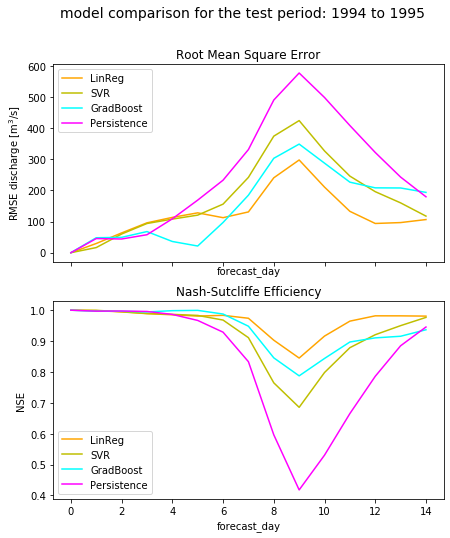

In [289]:
plot_metrics(list_of_models, suptitle='model comparison for the test period: 1994 to 1995')

### 2.2 Case study: May/June 2013; Flooding event at Krems (Danube river)

#### Load the "truth" (reanalysis) at the Krems gridpoint and the model forecasts, as well as the glofas forecast reruns

In [7]:
truth_case = xr.open_dataset('../../data/glofas_reanalysis_case_study.nc')['dis']
fc_lr_case = xr.open_dataset('../../data/models/LinearRegression/linear_regression_result_case_study.nc')['prediction']
fc_svr_case = xr.open_dataset('../../data/models/SVR/support_vector_regression_result_case_study.nc')['prediction']
fc_gb_case = xr.open_dataset('../../data/models/GradientBoost/gradient_boost_result_case_study.nc')['prediction']
# tdnn: fc_tdnn_test = xr.open_dataset('../../data/models/-----.nc')['prediction']
# cnn: fc_cnn_test = xr.open_dataset('../../data/models/-----.nc')['prediction']
glo_fr_case = xr.open_dataset('../../data/glofas_freruns_case_study.nc')['forecast rerun']

Check only the median of the forecast reruns.

In [ ]:
glo_fr_case_median = glo_fr_case.median(dim='ensemble');

Due to the different structure of the case study data (fixed total time, overlapping forecasts) a small preprocessing routine is neede.

In [9]:
def preproc_multif_case(multif):
    multif_list = []
    fc_range = range(0,31)
    for fc in multif.num_of_forecast:
        data = multif.sel(num_of_forecast=fc).dropna(dim='time')
        fc_da = xr.DataArray(data.values,
                             coords={'forecast_day': fc_range,
                                     'time': (('forecast_day'), data.time.values)},
                             dims='forecast_day')
        multif_list.append(fc_da)
    new_da = xr.concat(multif_list, dim='num_of_forecast')
    new_da.name = 'prediction'
    return new_da

Construct the persistence forecast.

In [91]:
# directly select the few starting points for the small case study
truth_init = np.array([truth_case.sel(time='2013-05-18').values,
                       truth_case.sel(time='2013-05-22').values,
                       truth_case.sel(time='2013-05-25').values,
                       truth_case.sel(time='2013-05-29').values])
persistence_data = np.tile(truth_init, (31, 1)).transpose()
persistence_case = preproc_multif_case(fc_lr_case).copy()
persistence_case.values = persistence_data

In [93]:
lr_case = multif_metrics(preproc_multif_case(fc_lr_case), truth_case, method='per_day', name='LinReg')
svr_case = multif_metrics(preproc_multif_case(fc_svr_case), truth_case, method='per_day', name='SVR')
gb_case = multif_metrics(preproc_multif_case(fc_gb_case), truth_case, method='per_day', name='GradBoost')
#tdnn_case = multif_metrics(preproc_multif_case(fc_tdnn_case), truth_case, method='per_day', name='Time-delay neural net')
fr_case = multif_metrics(preproc_multif_case(glo_fr_case_median), truth_case, method='per_day', name='forecast_rerun_median')
per_case = multif_metrics(persistence_case, truth_case, method='per_day', name='Persistence')

list_of_models_case = [lr_case, svr_case, gb_case, fr_case, per_case]# , tdnn_case]

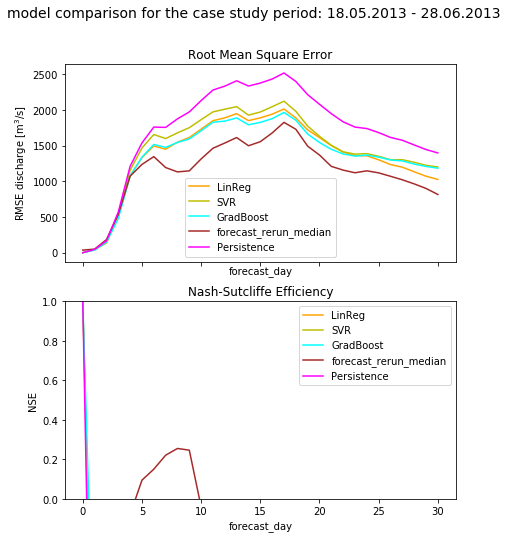

In [290]:
plot_metrics(list_of_models_case, suptitle='model comparison for the case study period: 18.05.2013 - 28.06.2013')
plt.ylim([0, 1]);

The results for the case study do not look that great. Does that mean all was a failure? Certainly not. First of all, lets quickly look at the time series themselves:

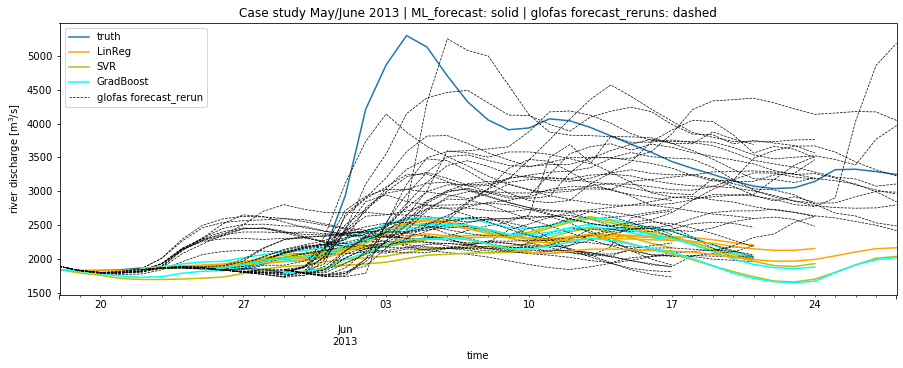

In [293]:
fig, ax = plt.subplots(figsize=(15, 5))
truth_case.to_pandas().plot(ax=ax, label='truth')
color_scheme = ['orange', 'y', 'cyan', 'k']

for i in fc_lr_case.num_of_forecast:
    fc_lr_case.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='LinReg', color=color_scheme[0])
    fc_svr_case.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='SVR', color=color_scheme[1])
    fc_gb_case.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='GradBoost', color=color_scheme[2])
    glo_fr_case.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='glofas forecast_rerun', linewidth=0.7,
                                                            linestyle='--', color=color_scheme[3])
ax.set_ylabel('river discharge [m$^3$/s]')
plt.legend(['truth', 'LinReg', 'SVR', 'GradBoost', 'glofas forecast_rerun'])
plt.title('Case study May/June 2013 | ML_forecast: solid | glofas forecast_reruns: dashed');

So, it seems that the sudden increase in discharge at this observed location with the accompying flooding events along the Danube were not captured that well in the Glofas forecast reruns as well on the one hand and no ML model is able to show adequat response. Even though, a slight increase at the "correct" time can be seen.

Does this mean that the ML models presented here can not forecat sudden increase in discharge values? Let us therefor look at another case (Note that we do not have Glofas forecast rerun data available for other periods, hence only the ML model forecast are intercompared to each other).

### 2.3 Broadly check the test period for forecasts of sudden increases in river discharge

In [136]:
truth_test = xr.open_dataset('../../data/glofas_reanalysis_test_period.nc')['dis']
fc_lr_test = xr.open_dataset('../../data/models/LinearRegression/linear_regression_result_test_period.nc')['prediction']
fc_svr_test = xr.open_dataset('../../data/models/SVR/support_vector_regression_result_test_period.nc')['prediction']
fc_gb_test = xr.open_dataset('../../data/models/GradientBoost/gradient_boost_result_test_period.nc')['prediction']
# tdnn: fc_tdnn_test = xr.open_dataset('../../data/models/-----.nc')['prediction']
# cnn: fc_cnn_test = xr.open_dataset('../../data/models/-----.nc')['prediction']

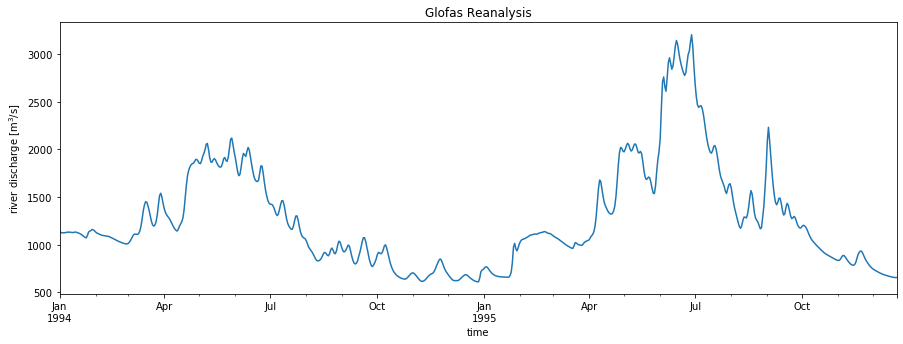

In [137]:
fig, ax = plt.subplots(figsize=(15, 5))
truth_test.to_pandas().plot()
ax.set_ylabel('river discharge [m$^3$/s]')
plt.title('Glofas Reanalysis');

Let us determine the times when the most steep ascents from the test period happened.

In [148]:
truth_diff = truth_test.diff('time')
event_times = truth_diff.where(truth_diff >= np.sort(truth_diff.values)[-25], drop=True).time.values
print(event_times)

['1994-03-27T00:00:00.000000000' '1994-04-19T00:00:00.000000000'
 '1994-04-20T00:00:00.000000000' '1995-01-26T00:00:00.000000000'
 '1995-04-07T00:00:00.000000000' '1995-04-08T00:00:00.000000000'
 '1995-04-09T00:00:00.000000000' '1995-04-25T00:00:00.000000000'
 '1995-04-26T00:00:00.000000000' '1995-04-27T00:00:00.000000000'
 '1995-05-29T00:00:00.000000000' '1995-05-30T00:00:00.000000000'
 '1995-06-01T00:00:00.000000000' '1995-06-02T00:00:00.000000000'
 '1995-06-03T00:00:00.000000000' '1995-06-07T00:00:00.000000000'
 '1995-06-08T00:00:00.000000000' '1995-06-14T00:00:00.000000000'
 '1995-08-17T00:00:00.000000000' '1995-08-28T00:00:00.000000000'
 '1995-08-29T00:00:00.000000000' '1995-08-30T00:00:00.000000000'
 '1995-08-31T00:00:00.000000000' '1995-09-01T00:00:00.000000000'
 '1995-09-02T00:00:00.000000000']


Looking at the above query, a lot of the points are obviously clustered, because the discharge itself is sluggish. Plotting vertical lines atop the time series gives a cleaner picture.

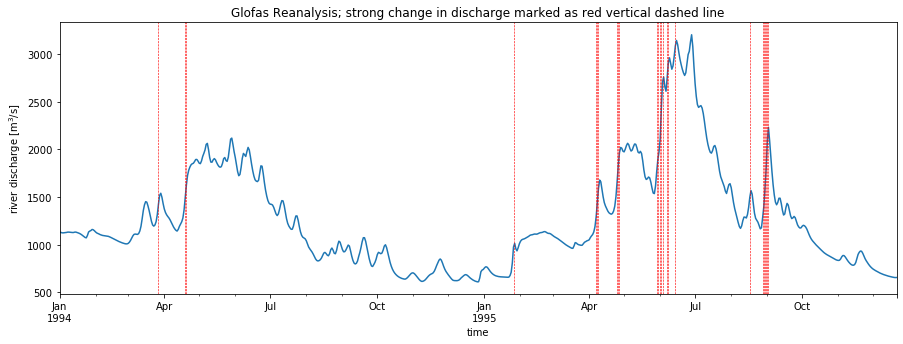

In [150]:
fig, ax = plt.subplots(figsize=(15, 5))
truth_test.to_pandas().plot()
for event in event_times:
    ax.axvline(event, color='r', linestyle='--', linewidth=0.6)
ax.set_ylabel('river discharge [m$^3$/s]')
plt.title('Glofas Reanalysis; strong change in discharge marked as red vertical dashed line');

Now, for each cluster, the earliest data point is the starting point, from which we go into the past until we hit an initial forecast state as provided by the calculated model forecasts.

In [224]:
event_times_small = [np.datetime64('1994-03-27'), np.datetime64('1994-04-19'),
                     np.datetime64('1995-01-26'), np.datetime64('1995-04-05'),
                     np.datetime64('1995-04-25'), np.datetime64('1995-05-29'),
                     np.datetime64('1995-08-28')]
# keys, corresponding to the closest forecast init time from the event time
keys = [5, 7, 25, 30, 31, 34, 40]

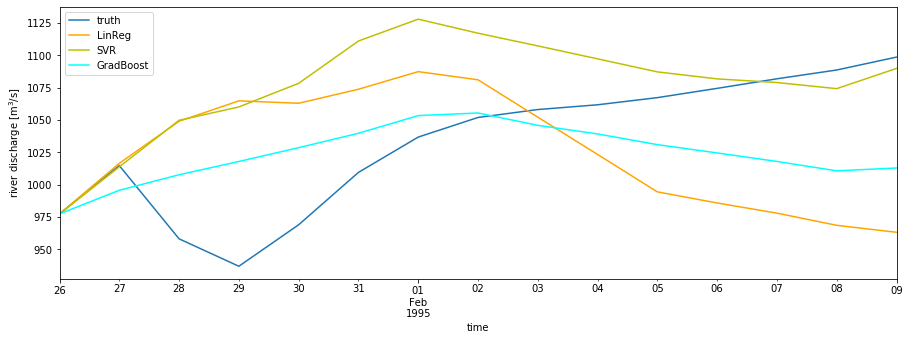

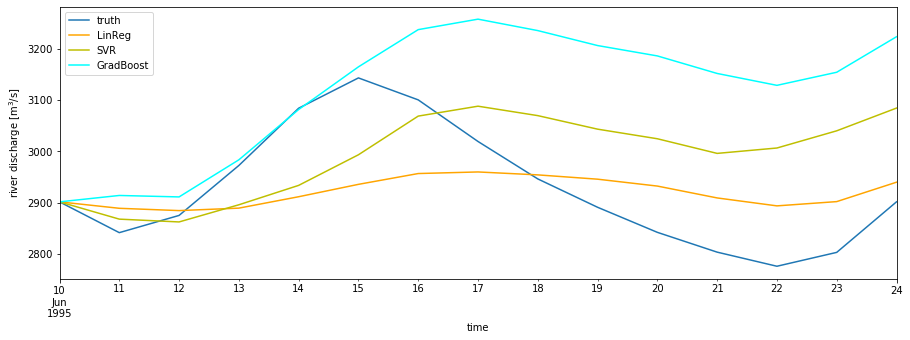

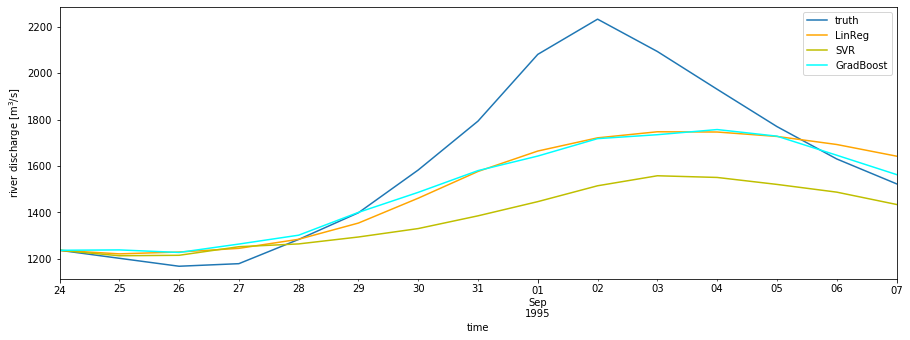

In [283]:
def plot_single_case_prediction(list_of_models, y_truth, title=None):
    """Convenience function for plotting multiple model forecasts and truth.
    
    Parameters
    ----------
        pred_multif     : list containing xr.DataArray objects
        y_truth         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15,5))
    time_index = list_of_models[0].time.values
    y_truth.sel({'time': time_index}).to_pandas().plot(ax=ax, label='truth')
    
    color_scheme = ['orange', 'y', 'cyan', 'magenta', 'brown']
    pd.Series(data=list_of_models[0].values, index=time_index).plot(ax=ax, label='LinReg', color=color_scheme[0])
    pd.Series(data=list_of_models[1].values, index=time_index).plot(ax=ax, label='SVR', color=color_scheme[1])
    pd.Series(data=list_of_models[2].values, index=time_index).plot(ax=ax, label='GradBoost', color=color_scheme[2])
    
    
    plt.legend()

    ax.set_ylabel('river discharge [m$^3$/s]')
    return fig, ax

keys = [26, 35, 40]
for k in keys:
    list_of_models_test = [fc_lr_test[k,:], fc_svr_test[k,:], fc_gb_test[k,:]]
    plot_single_case_prediction(list_of_models_test, truth_test)

In [278]:
# initial state used for persistence
truth_init = truth_test.values.reshape(fc_lr_test.shape)[:,0]
# repeat the initial state for the whole forecast period i.e. persistence forecast
persistence_data = np.tile(truth_init, (15, 1)).transpose()
# easy way to get the same shape, dims, coords etc
persistence_test = fc_lr_test.copy()
persistence_test.values = persistence_data

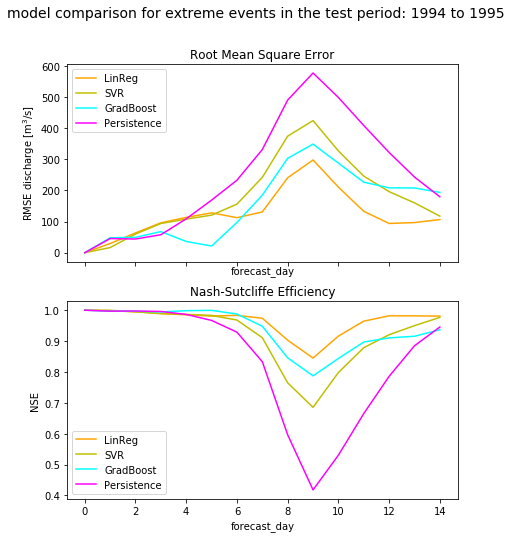

In [286]:
lr_test = multif_metrics(fc_lr_test[keys,:], truth_test, method='per_day', name='LinReg')
svr_test = multif_metrics(fc_svr_test[keys,:], truth_test, method='per_day', name='SVR')
gb_test = multif_metrics(fc_gb_test[keys,:], truth_test, method='per_day', name='GradBoost')
#tdnn_test = multif_metrics(fc_tdnn_test[keys,:], truth_test, method='per_day', name='Time-delay neural net')
per_test = multif_metrics(persistence_test[keys,:], truth_test, method='per_day', name='Persistence')

list_of_models = [lr_test, svr_test, gb_test, per_test]# , tdnn_test]
plot_metrics(list_of_models, suptitle='model comparison for extreme events in the test period: 1994 to 1995')